(synth_ntbk)=

# Generate synthetic clusters

This tutorial shows how you can generate synthetic clusters with **ASteCA**.

We start by instantiating an `isochrones` object with a PARSEC isochrone. This is an example file but you can use whatever isochrone service fits your needs:

In [1]:
import asteca

# Load isochrones
isochs = asteca.isochrones(
    model='parsec',
    isochs_path="../_static/parsec/",
    magnitude="Gmag",
    color=("G_BPmag", "G_RPmag"),
    magnitude_effl=6390.7,
    color_effl=(5182.58, 7825.08),
    verbose=2
)


Instantiating isochrones...
Model          : PARSEC
N_files        : 1
N_met          : 3
N_age          : 11
N_isoch        : 2500
z   range      : [0.01, 0.02]
loga range     : [7.0, 9.5]
Magnitude      : Gmag
Color          : G_BPmag-G_RPmag
Isochrone object generated


Next we instantiate a `synthetic` object, using the `isochs` object we just created. We are using all default values for the arguments of `asteca.synthetic()` (and a fixed seed for reproducibility):

In [2]:
# Synthetic clusters parameters
synthcl = asteca.synthetic(isochs, seed=457304, verbose=2)


Instantiating synthetic...
IMF            : chabrier_2014
Max init mass  : 20000
Gamma dist     : D&K
Extinction law : CCMO
Diff reddening : uniform
Random seed    : 457304
Synthetic clusters object generated


Now we just need to feed the `synthcl` object a dictionary with values for the eight required fundamental parameters:

In [3]:
params = {"alpha": 0.1, "beta": 1.0, "Rv": 3.1, "met": 0.0152, "DR": 0., "loga": 8.0, "dm": 10, "Av": 0.2}
synth_arr = synthcl.generate(params)
print(synth_arr.shape)

(4, 100)


The `synth_arr` array of shape `(Ndim, Nstars)` contains data associated to a synthetic cluster, generated with the fundamental parameters stored in the `params` dictionary. The array contains `Ndim=4` columns which are: magnitude, color, primary stellar mass and secondary stellar mass; i.e.: the mass of the secondary member of the binary system (a value of `np.nan` for this mass means that the system is not binary). 

By default the `synthcl.generate()` method generates `Nstars=100` stars but we can modify that via the `N_stars` argument:

In [4]:
params = {"alpha": 0.1, "beta": 1.0, "Rv": 3.1, "met": 0.0152, "DR": 0., "loga": 8.0, "dm": 10, "Av": 0.2}
synth_arr = synthcl.generate(params, N_stars=250)
print(synth_arr.shape)

(4, 250)


We can plot the resulting array to generate a synthetic CMD (color-magnitude diagram):

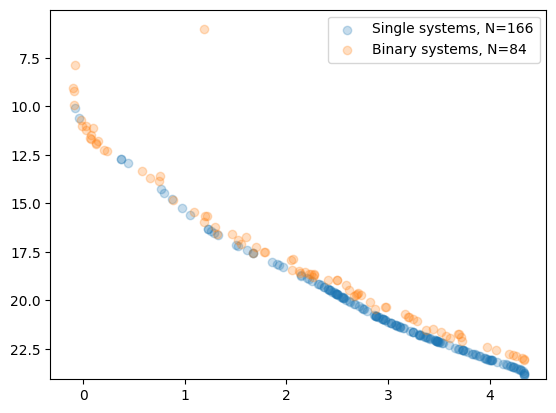

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def cmd_plot(color, mag, label, ax=None):
    """Function to generate a CMD plot"""
    if ax is None:
        ax = plt.subplot(111)
    label = label + f", N={len(mag)}"
    ax.scatter(color, mag, alpha=0.25, label=label)
    ax.legend()
    ax.set_ylim(mag.max() + 1, mag.min() - 1)  # Invert y axis


# Generate a boolean mask identifying the binary systems
# as those where the secondary mass values are *not* np.nan
binary_msk = ~np.isnan(synth_arr[-1])

# Extract magnitude and color
mag, color = synth_arr[0], synth_arr[1]

# Plot single systems
cmd_plot(color[~binary_msk], mag[~binary_msk], "Single systems")

# Plot binary systems
cmd_plot(color[binary_msk], mag[binary_msk], "Binary systems")

Notice that in the above plot the maximum magnitude value is given by the maximum value allowed by the theoretical isochrones. Also, the synthetic  photometric data has no associated uncertainties. The next section shows how both the maximum observed magnitude and the photometric uncertainties, as well as the number of synthetic stars, can be extracted from an observed cluster data file.

## Calibrating an observed cluster

Assuming we have a cluster file composed only of the most probable members of a given cluster cluster, we first load the file as a `pandas.DataFrame()` and use this to define a ``asteca.cluster()`` object:

In [7]:
import pandas as pd

obs_df = pd.read_csv("../_static/cluster.csv")

my_cluster = asteca.cluster(
    magnitude=obs_df["Gmag"],
    e_mag=obs_df["e_Gmag"],
    color=obs_df["BP-RP"],
    e_color=obs_df['e_BP-RP'],
    verbose=2
)


Instantiating cluster...
Columns read   : Magnitude, e_mag, Color, e_color
N_stars        : 2759
N_clust_min    : 25
N_clust_max    : 5000
Cluster object generated


The CMD of the observed cluster looks like:

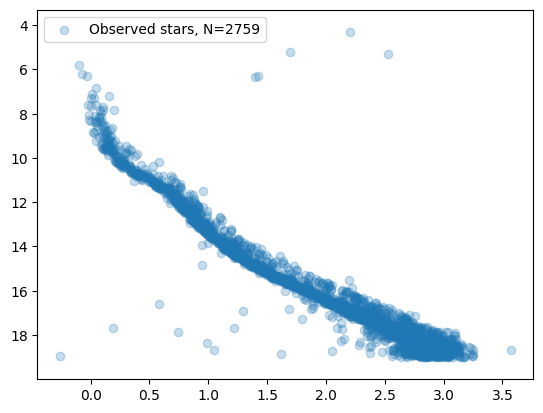

In [8]:
cmd_plot(my_cluster.color, my_cluster.mag, "Observed stars")

To calibrate the `synthcl` object we simply feed the `my_cluster` object to the  `calibrate()` method:

In [9]:
# Calibrate the `synthcl` object
synthcl.calibrate(my_cluster)

The number of synthetic stars, the maximum magnitude value and the distribution of photometric uncertainties are now extracted from the oberved cluster data.

We can generate a synthetic cluster _calibrated to the observed data_ simply by calling the `generate()` method with a dictionary of parameters, as done in the previous section:

In [10]:
params = {"alpha": 0.1, "beta": 1.0, "Rv": 3.1, "met": 0.0152, "DR": 0., "loga": 8.0, "dm": 10, "Av": 0.2}
synth_arr = synthcl.generate(params)
print(synth_arr.shape)

(4, 2759)


Notice that the array now contains the same number of synthetic stars as those present in the observed cluster. Plotting both the observed and the synthetic cluster side by side we get:

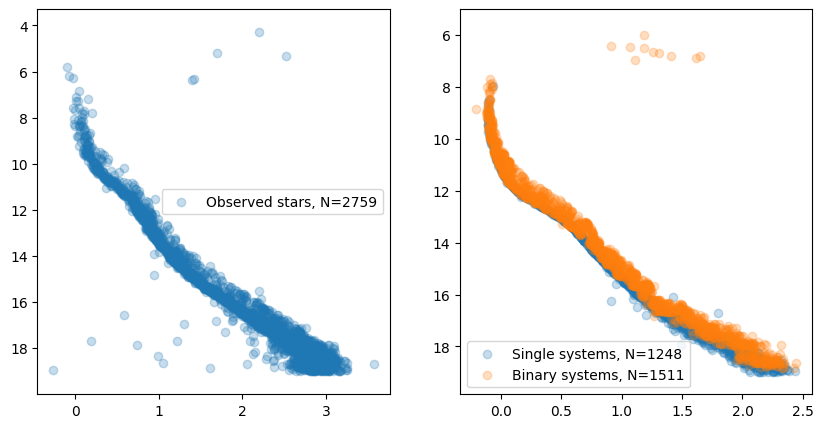

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Observed cluster
cmd_plot(my_cluster.color, my_cluster.mag, "Observed stars", ax1)

# Boolean mask identifying the binary systems
binary_msk = ~np.isnan(synth_arr[-1])
# Extract magnitude and color
mag, color = synth_arr[0], synth_arr[1]
# Plot single systems
cmd_plot(color[~binary_msk], mag[~binary_msk], "Single systems", ax2)
# Plot binary systems
cmd_plot(color[binary_msk], mag[binary_msk], "Binary systems", ax2)

where we see that the synthetic maximum magnitude now matches the observed one. Also the synthetic photometry now looks affected by the same uncertainty than the observed cluster, as expected.

Furthermore we can obtain the theoretical isochrone associated to the synthetic cluster via the `get_isochrone()` method, and add it to the plot:

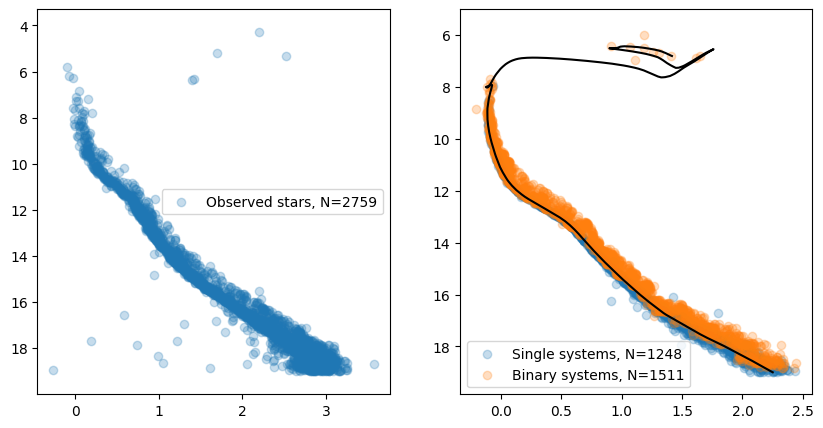

In [12]:
# Get isochrone associated to the synthetic cluster
isoch_arr = synthcl.get_isochrone(params)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Observed cluster
cmd_plot(my_cluster.color, my_cluster.mag, "Observed stars", ax1)

# Synthetic cluster
# Boolean mask identifying the binary systems
binary_msk = ~np.isnan(synth_arr[-1])
# Extract magnitude and color
mag, color = synth_arr[0], synth_arr[1]
# Plot single systems
cmd_plot(color[~binary_msk], mag[~binary_msk], "Single systems", ax2)
# Plot binary systems
cmd_plot(color[binary_msk], mag[binary_msk], "Binary systems", ax2)
# Plot the isochrone
ax2.plot(isoch_arr[1], isoch_arr[0], c="k");